# Contents
- [Imports](#imports)
- [ANN Modelling](#model)
- [ANN Testing](#test)
    - [Quantitative Test](#quant)
    - [Visual Test](#vid)
- [ANN Modelling and Testing 2](#ann2)
    - [Modelling](#model2)
    - [Quantitative Test](#quant2)
    - [Visual Test](#vid2)

---
# Imports<a id=imports></a>

In [50]:
import numpy as np
import pandas as pd
import requests
from IPython.display import HTML
from IPython.display import Image

from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, make_scorer, roc_curve, classification_report, precision_recall_curve, roc_auc_score

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import argparse
import logging
import time
import os
import re
import cv2
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

%matplotlib inline

We import our feature engineered dataset

In [2]:
data=pd.read_csv(r'.\data\feateng.csv')

---
# ANN Modelling<a id=model></a>
Having performed our modelling and testing with traditional machine learning methods, we shall next investigate the use of neural networks for our classification problem.<br/>
From the website [machinelearningmastery.com](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/), a simple explanation of neural networks is given:
> A neural network is comprised of layers of nodes and learns to map examples of inputs to outputs.<br/>
For a given node, the inputs are multiplied by the weights in a node and summed together. This value is referred to as the summed activation of the node. The summed activation is then transformed via an activation function and defines the specific output or “activation” of the node.

As we have shown in our feature engineering, our classifier works better when it is able to capture the relations between our different features, and it seems that neural networks might be able to learn these relations on their own for better performance.<br/>
As such we shall model and test an artifical neural network for our classifier.<br/>

Let us proceed by preparing our data.

In [6]:
X=data[[x for x in data.columns if x != 'move']]
y=data['move']

We have to one-hot encode our classes for a keras multi-class classifier.

In [7]:
y = to_categorical(y)
y[:5]

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

We SMOTE our data to achieve class balance, and as our ANN employs a gradient search method, we have to employ standard scaler on our datasets.

In [8]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X_res,y_res,random_state=42,stratify=y_res)

In [10]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [11]:
X_train_sc.shape

(15804, 24)

Next, we create a template for our artificial neural network. For our template, we have to decide on the number of hidden layers and our activation functions.<br/>
A good explanation/analogy of hidden layers is given in [this stats.stackexchange](https://stats.stackexchange.com/questions/63152/what-does-the-hidden-layer-in-a-neural-network-compute) post:
> Let's call the input vector x, the hidden layer activations h, and the output activation y. You have some function f that maps from x to h and another function g that maps from h to y.
<br/>So the hidden layer's activation is f(x) and the output of the network is g(f(x)).
<br/>Why have two functions (f and g) instead of just one?
<br/>If the level of complexity per function is limited, then g(f(x)) can compute things that f and g can't do individually.

However, as this project is not a mathematically rigorous investigation into predicting boxing movement, we avoid a rigorous approach to determining the number of hidden layers due to time constraints.<br/>
What we do know is that we want to capture the relationship between distances, shoulder width and spine length. As such, we set 3 hidden layers to account for any and all variations in these 3 relationships.<br/>
For our activation functions, we default to 'relu'(rectified linear unit) for our hidden layers and use 'softmax' for our output as we are performing a multiclass classification.

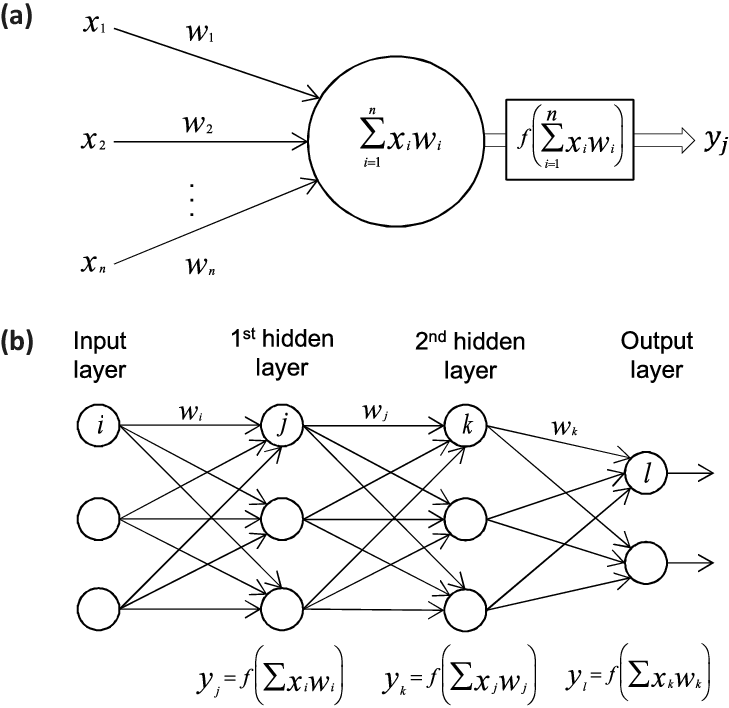

Example diagram of an Artificial Neural Network


In [51]:
url = 'https://www.researchgate.net/profile/Sandra_Vieira5/publication/312205163/figure/fig1/AS:453658144972800@1485171938968/a-The-building-block-of-deep-neural-networks-artificial-neuron-or-node-Each-input-x.png'
display(Image(requests.get(url).content))
print('Example diagram of an Artificial Neural Network')

In [4]:
def model_func(input_dimen=18,layr1_neurons=18,layr1_dropout=0.5,layr2_neurons=18,layr2_dropout=0.5,layr3_neurons=18,layr3_dropout=0.5):
    model = Sequential()
    model.add(Dense(layr1_neurons,
                    activation='relu',
                    input_dim=input_dimen
                   ))
    model.add(Dropout(layr1_dropout))
    
    model.add(Dense(layr2_neurons,
                   activation='relu'
                   ))
    model.add(Dropout(layr2_dropout))
    
    model.add(Dense(layr3_neurons,
                   activation='relu'
                   ))
    model.add(Dropout(layr3_dropout))
    
    model.add(Dense(6, 
                    activation='softmax'
                   ))
    
    model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy']
                  )
    
    return model

We then GridSearch our neural network to find the best parameters for our model.<br/>
I arbitrarily set epochs to 15 to speed up the modelling process.<br/>
For each hidden layer, I GridSearch through 24 and 30 neurons to allow for at least 24 perceptrons with our 24 features,<br/>
and for each hidden layer I GridSearch through 2 different dropout rates of 0.3 and 0.5.

In [12]:
%%time
nn = KerasClassifier(build_fn=model_func, 
                    epochs=100, 
                    verbose=1,
                    layr1_neurons=25,
                    input_dimen=X_train_sc.shape[1]
                   )

pipe = Pipeline([
    ('ss',ss),
    ('nn',nn)
])

params = {
    'nn__epochs':[15],
    'nn__layr1_neurons':[24,30],
    'nn__layr1_dropout':[0.3,0.5],
    'nn__layr2_neurons':[24,30],
    'nn__layr2_dropout':[0.3,0.5],
    'nn__layr3_neurons':[24,30],
    'nn__layr3_dropout':[0.3,0.5]
}

gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)

C:\Users\chang\.conda\envs\opencv\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/15
10536/10536 [==============================] - 15s 1ms/step - loss: 1.3880 - acc: 0.4657
Epoch 2/15
10536/10536 [==============================] - 3s 306us/step - loss: 0.8655 - acc: 0.6922
Epoch 3/15
10536/10536 [==============================] - 3s 309us/step - loss: 0.6908 - acc: 0.7648
Epoch 4/15
10536/10536 [==============================] - 3s 310us/step - loss: 0.5774 - acc: 0.8088
Epoch 5/15
10536/10536 [==============================] - 3s 311us/step - loss: 0.5190 - acc: 0.8327
Epoch 6/15
10536/10536 [==============================] - 3s 312us/step - loss: 0.4731 - acc: 0.8527
Epoch 7/15
10536/10536 [==============================] - 3s 311us/step - loss: 0.4428 - acc: 0.8615
Epoch 8/15
10536/10536 [==============================] - 3s 309us/step - loss: 0.4081 - acc: 0.8738
Epoch 9/15
10536/10536 [==============================] - 3s 306us/step - loss: 0.3946 - acc: 0.8770
Epoch 10/15
10536/10536 [==============================] - 3s 316us/step - loss: 0.3718 - ac

We obtain a GridSearched accuracy of 94% which is quite good.<br/>
Are best parameters are as follows.

In [13]:
gs.best_params_

{'nn__epochs': 15,
 'nn__layr1_dropout': 0.3,
 'nn__layr1_neurons': 30,
 'nn__layr2_dropout': 0.3,
 'nn__layr2_neurons': 30,
 'nn__layr3_dropout': 0.3,
 'nn__layr3_neurons': 30}

In [14]:
gs.score(X_test,y_test)

5268/5268 [==============================] - 19s 4ms/step


0.29650721334107644

However, scoring on our holdout data, we find that we get an accuracy value of 0.29 which is less than ideal.<br/>
Considering that scoring on holdout data was not fully indicative of the performance of our previous models, we take this with a pinch of salt and continue with further testing.<br/>

Let us recreate our model with the best parameters and save it to an external location.

In [21]:
model = KerasClassifier(build_fn=model_func, 
                    epochs=15, 
                    verbose=1,
                    layr1_neurons=30,
                    layr2_neurons=30,
                    layr3_neurons=30,
                    layr1_dropout=0.3,
                    layr2_dropout=0.3,
                    layr3_dropout=0.3,
                    input_dimen=X_train_sc.shape[1]
                   )

In [27]:
epochs = 15 
filepath = ".\data\keras1.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, verbose=1, 
     save_best_only=False)
callbacks = [checkpoint]
history=model.fit(X_train_sc, y_train, epochs=epochs, 
     shuffle=True, callbacks=callbacks)

Epoch 1/15
15804/15804 [==============================] - 53s 3ms/step - loss: 1.1499 - acc: 0.5762: 2s - loss: 1.1696 - acc

Epoch 00001: saving model to .\data\keras.hdf5
Epoch 2/15
15804/15804 [==============================] - 12s 773us/step - loss: 0.5828 - acc: 0.8088

Epoch 00002: saving model to .\data\keras.hdf5
Epoch 3/15
15804/15804 [==============================] - 12s 771us/step - loss: 0.4433 - acc: 0.8582

Epoch 00003: saving model to .\data\keras.hdf5
Epoch 4/15
15804/15804 [==============================] - 12s 757us/step - loss: 0.3757 - acc: 0.8868

Epoch 00004: saving model to .\data\keras.hdf5
Epoch 5/15
15804/15804 [==============================] - 12s 770us/step - loss: 0.3325 - acc: 0.89843s 

Epoch 00005: saving model to .\data\keras.hdf5
Epoch 6/15
15804/15804 [==============================] - 12s 772us/step - loss: 0.2954 - acc: 0.91070s - loss: 0.2957 - acc: 0.

Epoch 00006: saving model to .\data\keras.hdf5
Epoch 7/15
15804/15804 [=======================

---
# ANN Testing<a id=test></a>
## Quantitative Test<a id=quant></a>
Having saved our model, let us try performing a numerical test on our test data first and observe the performance of our neural network model.<br/>
We load our test data in the same way as in Testing_2.

In [40]:
none=pd.read_csv('../results/test/none.csv')
guard=pd.read_csv('../results/test/guard.csv')
jab=pd.read_csv('../results/test/jab.csv')
cross=pd.read_csv('../results/test/cross.csv')
hook=pd.read_csv('../results/test/hook.csv')
upcut=pd.read_csv('../results/test/uppercut.csv')

In [41]:
none['move']=0
guard['move']=1
jab['move']=2
cross['move']=3
hook['move']=4
upcut['move']=5

In [42]:
data=pd.concat([none,guard,jab,cross,hook,upcut],sort=True)
data.head()

,move,x0,x1,x10,x11,x12,x13,x14,x15,x16,...,y16,y17,y2,y3,y4,y5,y6,y7,y8,y9
0,0,0.75,0.69,NaN,0.63,0.67,NaN,0.75,NaN,0.71,...,0.12,NaN,0.26,0.54,0.79,0.27,NaN,NaN,0.68,0.90
1,0,0.75,0.68,NaN,0.62,0.63,NaN,0.75,NaN,0.71,...,0.13,NaN,0.26,0.53,0.79,0.27,NaN,NaN,0.67,0.88
2,0,0.74,0.68,NaN,0.63,0.66,NaN,0.74,NaN,0.70,...,0.13,NaN,0.26,0.52,0.79,0.27,NaN,NaN,0.67,0.89
3,0,0.74,0.67,NaN,0.62,0.64,NaN,0.74,NaN,0.70,...,0.14,NaN,0.26,0.52,0.78,0.27,NaN,NaN,0.69,0.91
4,0,0.73,0.67,NaN,0.63,NaN,NaN,0.73,NaN,0.69,...,0.14,NaN,0.27,0.52,0.78,0.27,NaN,NaN,0.69,0.91


In [43]:
xparts=['x1','x2','x3','x4','x5','x6','x7','x8','x11']
yparts=['y1','y2','y3','y4','y5','y6','y7','y8','y11']
drop=['x0', 'x10', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x9', 'y0', 'y10', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y9']
data.drop(columns=drop,inplace=True)

data[xparts]=data[xparts].subtract(data['x1'],axis=0)
data[yparts]=data[yparts].subtract(data['y1'],axis=0)
data.fillna(0,inplace=True)

data['shwidth']=np.hypot((data.x2-data.x5),(data.y2-data.y5))
data['splength']=np.hypot((data.x1-((data.x8+data.x11)/2)),(data.y1-((data.y8+data.y11)/2)))
data['lhnsh']=np.hypot((data.x7-data.x5),(data.y7-data.y5))*data.shwidth/data.splength
data['rhnsh']=np.hypot((data.x4-data.x2),(data.y4-data.y2))*data.shwidth/data.splength
data['lelsh']=np.hypot((data.x6-data.x5),(data.y6-data.y5))*data.shwidth/data.splength
data['relsh']=np.hypot((data.x3-data.x2),(data.y3-data.y2))*data.shwidth/data.splength

In [44]:
data.head()

,move,x1,x11,x2,x3,x4,x5,x6,x7,x8,...,y5,y6,y7,y8,shwidth,splength,lhnsh,rhnsh,lelsh,relsh
0,0,0.0,-0.06,0.02,0.08,0.17,-0.03,0.0,0.0,0.02,...,0.01,0.0,0.0,0.42,0.050990,0.420476,0.003835,0.066796,0.003835,0.034726
1,0,0.0,-0.06,0.02,0.07,0.17,-0.02,0.0,0.0,0.02,...,0.01,0.0,0.0,0.41,0.041231,0.405494,0.002274,0.056008,0.002274,0.027921
2,0,0.0,-0.05,0.02,0.07,0.16,-0.02,0.0,0.0,0.00,...,0.01,0.0,0.0,0.41,0.041231,0.405771,0.002272,0.055701,0.002272,0.026903
3,0,0.0,-0.05,0.02,0.06,0.15,-0.02,0.0,0.0,0.01,...,0.00,0.0,0.0,0.42,0.041231,0.415482,0.001985,0.053191,0.001985,0.026105
4,0,0.0,-0.04,0.02,0.05,0.14,-0.02,0.0,0.0,0.01,...,0.00,0.0,0.0,0.42,0.040000,0.415271,0.001926,0.050466,0.001926,0.024253


In [45]:
X=data[[x for x in data.columns if x != 'move']].to_numpy()
y=data['move']

In [40]:
pred=model.predict(X)

4000/4000 [==============================] - 19s 5ms/step


In [44]:
print(classification_report(y,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       926
           1       0.70      0.19      0.30      2271
           2       1.00      0.29      0.45       281
           3       0.00      0.00      0.00       195
           4       0.04      0.84      0.08       172
           5       0.00      0.00      0.00       155

    accuracy                           0.16      4000
   macro avg       0.29      0.22      0.14      4000
weighted avg       0.47      0.16      0.20      4000



Looking at the classification report on our test data, our accuracy is even worse than what we found in our holdout testing at 16%.<br/>
With great trepidation, let us try performing a visual test to observe how this model actually performs.<br/>

## Visual Test<a id=vid></a>

In [21]:
logger = logging.getLogger('TfPoseEstimator-Video')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

fps_time = 0

In [22]:
parser = argparse.ArgumentParser(description='tf-pose-estimation Video')
parser.add_argument('--video', type=str, default='')
parser.add_argument('--resolution', type=str, default='432x368', help='network input resolution. default=432x368')
parser.add_argument('--model', type=str, default='mobilenet_thin', help='cmu / mobilenet_thin / mobilenet_v2_large / mobilenet_v2_small')
parser.add_argument('--show-process', type=bool, default=False,
                    help='for debug purpose, if enabled, speed for inference is dropped.')
parser.add_argument('--showBG', type=bool, default=True, help='False to show skeleton only.')

_StoreAction(option_strings=['--showBG'], dest='showBG', nargs=None, const=None, default=True, type=<class 'bool'>, choices=None, help='False to show skeleton only.', metavar=None)

Our testing function can be run in exactly the same way with just changing to the correct name of the model.

In [23]:
def vidtest(args):
    
    fps_time = 0
    
    lis=[]
    for x in range(1,18):
        lis.append('x'+str(x))
        lis.append('y'+str(x))
    header=pd.DataFrame(columns=lis)
    
    xparts=['x1','x2','x3','x4','x5','x6','x7','x8','x11']
    yparts=['y1','y2','y3','y4','y5','y6','y7','y8','y11']
    drop=['x0', 'x10', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x9', 'y0', 'y10', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y9']
    
    logger.debug('initialization %s : %s' % (args.model, get_graph_path(args.model)))
    w, h = model_wh(args.resolution)
    e = TfPoseEstimator(get_graph_path(args.model), target_size=(w, h))
    cap = cv2.VideoCapture(args.video)

    if cap.isOpened() is False:
        print("Error opening video stream or file")
    while cap.isOpened():
        try:
            ret_val, image = cap.read()
            humans = e.inference(image, upsample_size=4.0)
        except:
            break
            
        if not args.showBG:
            image = np.zeros(image.shape)
        image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

        cv2.putText(image, "FPS: %f" % (1.0 / (time.time() - fps_time)), (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        move='none'

        try:
            part=re.findall('BodyPart:(.*?)-',str(humans[0]))
            xco=re.findall('\((.*?),',str(humans[0]))
            yco=re.findall(', (.*?)\)',str(humans[0]))
            xpart=['x'+c for c in part]
            ypart=['y'+c for c in part]
            test1=pd.DataFrame([[float(x) for x in xco+yco]],columns=xpart+ypart)
            data=pd.concat([header,test1],sort=True)

            data.drop(columns=drop,inplace=True) #create our new features based on our previous feature engineering
            data[xparts]=data[xparts].subtract(data['x1'],axis=0)
            data[yparts]=data[yparts].subtract(data['y1'],axis=0)
            data.fillna(0,inplace=True)
    
            data['shwidth']=np.hypot((data.x2-data.x5),(data.y2-data.y5))
            data['splength']=np.hypot((data.x1-((data.x8+data.x11)/2)),(data.y1-((data.y8+data.y11)/2)))
            data['lhnsh']=np.hypot((data.x7-data.x5),(data.y7-data.y5))*data.shwidth/data.splength
            data['rhnsh']=np.hypot((data.x4-data.x2),(data.y4-data.y2))*data.shwidth/data.splength
            data['lelsh']=np.hypot((data.x6-data.x5),(data.y6-data.y5))*data.shwidth/data.splength
            data['relsh']=np.hypot((data.x3-data.x2),(data.y3-data.y2))*data.shwidth/data.splength #end of feature creation
            
            predict=model.predict(data.to_numpy())
            if predict[0]==0:
                move='none'
            elif predict[0]==1:
                move='guard'
            elif predict[0]==2:
                move='jab'
            elif predict[0]==3:
                move='cross'
            elif predict[0]==4:
                move='hook'
            elif predict[0]==5:
                move='uppercut'
            else:
                move='none'

        except:
            move='not detected'

        finally:
            cv2.putText(image,
                        'move: '+move,
                        (10, 30),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 0, 255), 2)
            out.write(image)
            cv2.imshow('tf-pose-estimation result', image)
            fps_time = time.time()

            if cv2.waitKey(1) == 27:
                break
            
    cv2.destroyAllWindows()
    logger.debug('finished+')
    return(data)

Again, we set our output video codec to 'mp4v'.

In [24]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

And we perform our estimation, prediction and output with the loop below.

In [25]:
args=parser.parse_args(("--video=../results/test.mp4 --model=cmu").split())
writepath="../results/test3/keras1.mp4"
out=cv2.VideoWriter(writepath, fourcc, 30, (1280,720))
vidtest(args)

[2019-08-02 03:49:59,488] [TfPoseEstimator-Video] [DEBUG] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
[2019-08-02 03:49:59,488] [TfPoseEstimator-Video] [DEBUG] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
I0802 03:49:59.488362 16896 <ipython-input-23-2474e47a57c6>:15] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
[2019-08-02 03:49:59,492] [TfPoseEstimator] [INFO] loading graph from D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb(default size=432x368)
I0802 03:49:59.492352 16896 estimator.py:309] loading graph from D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb(default size=432x368)
W0802 03:49:59.494346 16896 

1/1 [==============================] - 0s 984us/step


[2019-08-02 03:57:29,631] [TfPoseEstimator-Video] [DEBUG] finished+
[2019-08-02 03:57:29,631] [TfPoseEstimator-Video] [DEBUG] finished+
I0802 03:57:29.631150 16896 <ipython-input-23-2474e47a57c6>:90] finished+


,x1,x11,x2,x3,x4,x5,x6,x7,x8,y1,...,y5,y6,y7,y8,shwidth,splength,lhnsh,rhnsh,lelsh,relsh
0,0.0,-0.04,-0.01,0.07,0.2,0.0,0,0,-0.05,0.0,...,-0.01,0,0,0.34,0.022361,0.338009,0.000662,0.028145,0.000662,0.01425


In [55]:
def showvideo(i):
    display(HTML("""<video width="1500" height="1000" controls><source src="{}" type="video/mp4"></video>""".format(i)))
    
showvideo('../results/test3/keras1.mp4')

We find that just as our quantitative test implied, this model tends to classify almost every action as a 'guard'.<br/>
Let us build an even simpler model to check if an ANN is usable for our purposes at all.

---
# ANN Modelling and Testing 2<a id=ann2></a>
## Modelling<a id=model2></a>
We shall create a new, simpler model with only one hidden layer.

In [34]:
def model_func(input_dimen=18,layr1_neurons=18,layr1_dropout=0.5):
    model = Sequential()
    model.add(Dense(layr1_neurons,
                    activation='relu',
                    input_dim=input_dimen
                   ))
    model.add(Dropout(layr1_dropout))
    
    model.add(Dense(6, 
                    activation='softmax'
                   ))
    
    model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy']
                  )
    
    return model

We set this model to train for 32 epochs, to have 18 neurons in the hidden layer, and to have a dropout rate of 0.3.

In [35]:
model = KerasClassifier(build_fn=model_func, 
                    epochs=32, 
                    verbose=1,
                    layr1_neurons=18,
                    layr1_dropout=0.3,
                    input_dimen=X_train_sc.shape[1]
                   )

In [37]:
filepath = ".\data\keras2.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, verbose=1, 
     save_best_only=False)
callbacks = [checkpoint]
history=model.fit(X_train_sc, y_train, 
     shuffle=True, callbacks=callbacks)

Epoch 1/32
15804/15804 [==============================] - ETA: 28:21 - loss: 2.1935 - acc: 0.18 - ETA: 2:00 - loss: 2.1644 - acc: 0.2277 - ETA: 57s - loss: 2.0790 - acc: 0.222 - ETA: 36s - loss: 2.0010 - acc: 0.24 - ETA: 25s - loss: 1.9333 - acc: 0.25 - ETA: 19s - loss: 1.8869 - acc: 0.26 - ETA: 16s - loss: 1.8437 - acc: 0.27 - ETA: 13s - loss: 1.7989 - acc: 0.28 - ETA: 11s - loss: 1.7517 - acc: 0.30 - ETA: 9s - loss: 1.7212 - acc: 0.3112 - ETA: 8s - loss: 1.6868 - acc: 0.324 - ETA: 7s - loss: 1.6570 - acc: 0.337 - ETA: 6s - loss: 1.6283 - acc: 0.352 - ETA: 5s - loss: 1.5939 - acc: 0.367 - ETA: 5s - loss: 1.5709 - acc: 0.379 - ETA: 4s - loss: 1.5469 - acc: 0.391 - ETA: 4s - loss: 1.5260 - acc: 0.402 - ETA: 3s - loss: 1.5044 - acc: 0.415 - ETA: 3s - loss: 1.4842 - acc: 0.424 - ETA: 3s - loss: 1.4663 - acc: 0.434 - ETA: 2s - loss: 1.4502 - acc: 0.443 - ETA: 2s - loss: 1.4319 - acc: 0.451 - ETA: 2s - loss: 1.4134 - acc: 0.460 - ETA: 1s - loss: 1.3980 - acc: 0.468 - ETA: 1s - loss: 1.3830 

Our initial accuracy seems to be at 92% which is not bad considering how much simpler this model is.<br/>
Let us move ahead with testing.

## Quantitative Testing<a id=quant2></a>

In [46]:
pred=model.predict(X)

4000/4000 [==============================] - ETA:  - ETA:  - ETA:  - 0s 30us/step


In [47]:
print(classification_report(y,pred))

C:\Users\chang\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.35      0.92      0.51       926
           1       0.94      0.65      0.77      2271
           2       1.00      0.03      0.06       281
           3       0.00      0.00      0.00       195
           4       0.00      0.00      0.00       172
           5       0.00      0.00      0.00       155

    accuracy                           0.59      4000
   macro avg       0.38      0.27      0.22      4000
weighted avg       0.68      0.59      0.56      4000



This model performs better than our previous model. However, this model is still not predicting our crosses, hooks and uppercuts with most predictions going to guards and jabs. It seems overfitting is still present.

## Visual Testing<a id=vid2></a>

In [48]:
writepath="../results/test3/keras2.mp4"
out=cv2.VideoWriter(writepath, fourcc, 30, (1280,720))
vidtest(args)

[2019-08-02 04:18:05,549] [TfPoseEstimator-Video] [DEBUG] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
[2019-08-02 04:18:05,549] [TfPoseEstimator-Video] [DEBUG] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
I0802 04:18:05.549075 16896 <ipython-input-23-2474e47a57c6>:15] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
[2019-08-02 04:18:05,552] [TfPoseEstimator] [INFO] loading graph from D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb(default size=432x368)
I0802 04:18:05.552067 16896 estimator.py:309] loading graph from D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb(default size=432x368)


1/1 [==============================] - 0s 998us/step


[2019-08-02 04:29:32,433] [TfPoseEstimator-Video] [DEBUG] finished+
[2019-08-02 04:29:32,433] [TfPoseEstimator-Video] [DEBUG] finished+
I0802 04:29:32.433358 16896 <ipython-input-23-2474e47a57c6>:90] finished+


,x1,x11,x2,x3,x4,x5,x6,x7,x8,y1,...,y5,y6,y7,y8,shwidth,splength,lhnsh,rhnsh,lelsh,relsh
0,0.0,-0.04,-0.01,0.07,0.2,0.0,0,0,-0.05,0.0,...,-0.01,0,0,0.34,0.022361,0.338009,0.000662,0.028145,0.000662,0.01425


In [54]:
showvideo('../results/test3/keras2.mp4')

We can observe that our model classifies most moves as being 'none', with it being capable of predicting some guards ands a minute amount of jabs.<br/>
It seems that the ANN architecture can be tweaked to be useable for our purposes, however it will take some tuning with the hyperparammeters and probably a much larger dataset to work with.